In [22]:
import numpy as np
import pandas as pd
from utils import Options
from mvpa.loading import load_betas
from mvpa.mvpa_utils import split_expunexp
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
import nibabel as nb
from glob import glob

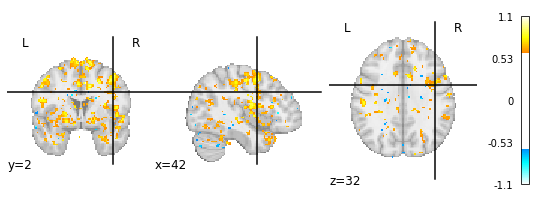

In [27]:
plot_stat_map('../../FIR_correlations/ba-17-18_contr-objscrvsbas_top-500/sub-002_exp.nii', threshold=0.6)

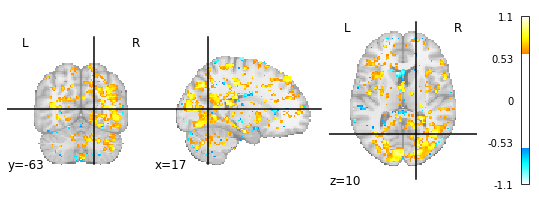

In [28]:
plot_stat_map('../../FIR_correlations/ba-17-18_contr-objscrvsbas_top-500/sub-002_unexp.nii', threshold=0.6)

In [2]:
tc = pd.read_csv('infocoupling/FIR_timecourses/sub-001_ba-17-18_contr-objscrvsbas_top-500.csv')
n_timepoints = tc.delay.nunique()
tc = tc.groupby(['delay', 'expected']).mean().reset_index()

In [3]:
tc.testmodel.unique()

array([15.])

In [4]:
opt = Options(
    sub='sub-001',
    task='test',
    model=27
)

In [5]:
wholebrainDS = load_betas(opt, mask_templ=None, fir=True)

  0%|          | 0/329 [00:00<?, ?it/s]

 * Please note: warnings are printed only once, but underlying problem might occur many times *


100%|██████████| 329/329 [03:05<00:00,  1.77it/s]


In [6]:
wholebrainDS.a.voxel_dim

(79, 95, 79)

In [7]:
wholebrainDS.fa.voxel_indices.shape

(592892, 3)

In [8]:
np.max(wholebrainDS.fa.voxel_indices, axis=0)

array([78, 94, 78])

In [9]:
n_voxels = wholebrainDS.samples.shape[1]
wholebrainDS = split_expunexp(wholebrainDS)
nanmask = np.all(np.isfinite(wholebrainDS.samples), axis=0)
wholebrainDS = wholebrainDS[:, nanmask]

In [10]:
wholebrainDS.samples.shape

(280, 206537)

In [11]:
univar_df = pd.DataFrame(
        {'delay': wholebrainDS.sa.delay,
         'expected': wholebrainDS.sa.expected,
         'samples': list(wholebrainDS.samples)}
    )
univar_df = univar_df.groupby(['delay', 'expected']).mean().reset_index()

In [12]:
# Get (n. voxels x n. timepoints) arrays for exp and unexp
exp_univar_array = np.vstack(univar_df[univar_df.expected==1].samples).T
unexp_univar_array = np.vstack(univar_df[univar_df.expected==0].samples).T
# Normalize
exp_univar_array = (exp_univar_array - np.mean(exp_univar_array, axis=1, keepdims=True))/np.std(exp_univar_array, axis=1, keepdims=True)
unexp_univar_array = (unexp_univar_array - np.mean(unexp_univar_array, axis=1, keepdims=True))/np.std(unexp_univar_array, axis=1, keepdims=True)

In [13]:
# Same thing for multivariate sequence
exp_multivar_array = np.hstack(tc[tc.expected==True].distance).reshape(1, n_timepoints)
unexp_multivar_array = np.hstack(tc[tc.expected==False].distance).reshape(1, n_timepoints)
exp_multivar_array = (exp_multivar_array - np.mean(exp_multivar_array, axis=1, keepdims=True))/np.std(exp_multivar_array, axis=1, keepdims=True)
unexp_multivar_array = (unexp_multivar_array - np.mean(unexp_multivar_array, axis=1, keepdims=True))/np.std(unexp_multivar_array, axis=1, keepdims=True)

In [14]:
# Compute Pearsons correlations
exp_corrs = np.dot(exp_univar_array, exp_multivar_array.T)/(n_timepoints-1)
unexp_corrs = np.dot(unexp_univar_array, unexp_multivar_array.T)/(n_timepoints-1)

In [15]:
# Convert into brain maps
i, j, k = wholebrainDS.fa.voxel_indices.T

exp_map = np.full(wholebrainDS.a.voxel_dim, np.nan)
exp_map[i, j, k] = exp_corrs.flatten()
exp_map = new_img_like('/project/3018040.05/anat_roi_masks/wholebrain.nii', exp_map)

unexp_map = np.full(wholebrainDS.a.voxel_dim, np.nan)
unexp_map[i, j, k] = unexp_corrs.flatten()
unexp_map = new_img_like('/project/3018040.05/anat_roi_masks/wholebrain.nii', unexp_map)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


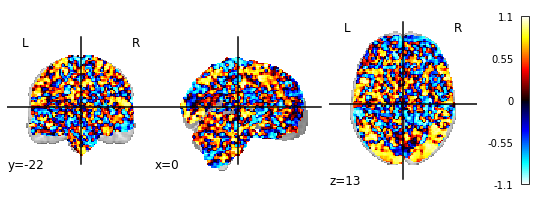

In [16]:
plot_stat_map(exp_map)

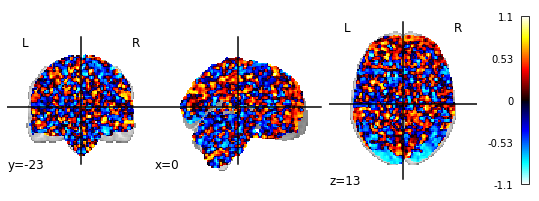

In [17]:
plot_stat_map(unexp_map)

In [20]:
nb.save(exp_map, 'exp_map.nii')

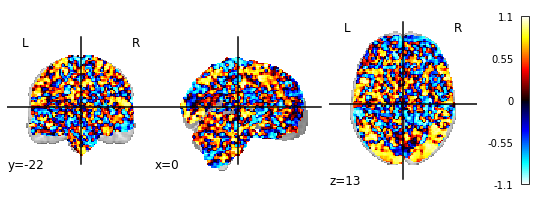

In [21]:
plot_stat_map('exp_map.nii')